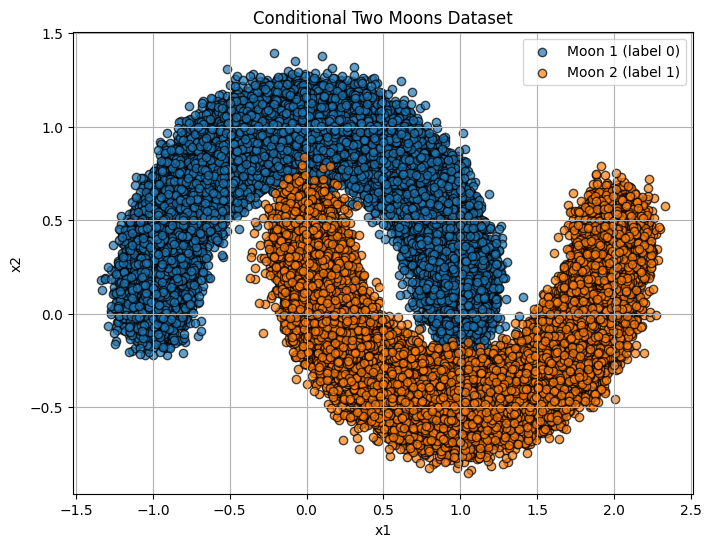

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm import trange
from torch.optim.lr_scheduler import CosineAnnealingLR
from typing import Tuple, List
import torch
import torch.nn as nn
import torch.nn.functional as F


def generate_conditional_two_moons(n_samples=1000, noise=0.1):
    """
    Generate a two moons dataset with conditional labels.

    Args:
        n_samples (int): Total number of samples.
        noise (float): Standard deviation of Gaussian noise added to the data.

    Returns:
        X (np.ndarray): The 2D points, shape (n_samples, 2).
        y (np.ndarray): The labels, shape (n_samples,).
    """
    # Generate the two moons data
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)

    return X, y


# Parameters
n_samples = 100000
noise = 0.1

# Generate data
X, y = generate_conditional_two_moons(n_samples=n_samples, noise=noise)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(
    X[y == 0, 0], X[y == 0, 1], label="Moon 1 (label 0)", alpha=0.7, edgecolor="k"
)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label="Moon 2 (label 1)", alpha=0.7, edgecolor="k"
)
plt.title("Conditional Two Moons Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid()
plt.show()

In [2]:
from flow_matching import ODEFlow, ConditionalODEFlow

In [3]:
# prepare the training data
targets = torch.tensor(X, dtype=torch.float32)  # (batch_size, n_covariates)
batch_size, n_covariates = targets.size()

# which moon? 1/0
conditional = torch.tensor(y[..., None], dtype=torch.float32)

# shifts and scales
target_shift = targets.mean(dim=0)
target_scale = targets.std(dim=0)
conditional_shift = conditional.mean(dim=0)
conditional_scale = conditional.std(dim=0)

# make a model
model = ConditionalODEFlow(
    target_dimension=2,
    conditional_dimension=1,
    hidden_units=[128, 128],
    activation=nn.SiLU,
    target_shift=target_shift,
    target_scale=target_scale,
    conditional_shift=conditional_shift,
    conditional_scale=conditional_scale,
)

# training loop for the flow matching model

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm import trange
from torch.optim.lr_scheduler import CosineAnnealingLR

batch_size = 128

dataloader = DataLoader(
    TensorDataset(targets, conditional),
    shuffle=True,
    batch_size=batch_size,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
model.train()

epochs = 100
scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(dataloader), eta_min=1e-6)
with trange(epochs) as t:
    for epoch in t:
        for targets_, conditional_ in dataloader:

            optimizer.zero_grad()

            loss = -model.log_prob(targets_, conditional_).mean()

            loss.backward()

            optimizer.step()
            scheduler.step()

            t.set_postfix(ordered_dict={"loss": loss.detach().item()})

  1%|          | 1/100 [01:19<2:11:25, 79.65s/it, loss=0.384]


KeyboardInterrupt: 

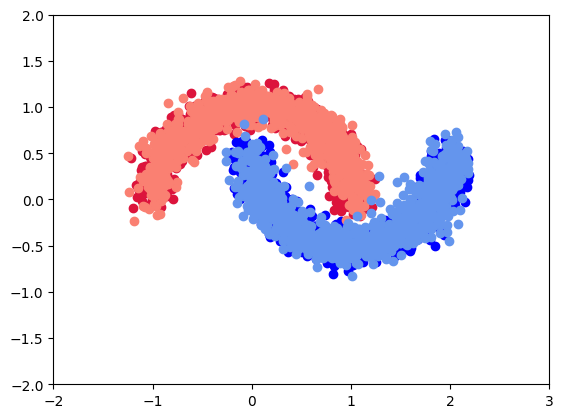

In [ ]:
n_samples = 1000
samples1 = model.sample(torch.randn(n_samples, 2), torch.zeros(n_samples, 1))
samples2 = model.sample(torch.randn(n_samples, 2), torch.ones(n_samples, 1))

targets1 = targets[y == 0]
targets2 = targets[y == 1]
plt.scatter(
    targets1[0:1000, 0].detach().numpy(),
    targets1[0:1000, 1].detach().numpy(),
    color="crimson",
)
plt.scatter(
    targets2[0:1000, 0].detach().numpy(),
    targets2[0:1000, 1].detach().numpy(),
    color="blue",
)
plt.scatter(
    samples1[:, 0].detach().numpy(), samples1[:, 1].detach().numpy(), color="salmon"
)
plt.scatter(
    samples2[:, 0].detach().numpy(),
    samples2[:, 1].detach().numpy(),
    color="cornflowerblue",
)
plt.xlim(-2, 3)
plt.ylim(-2, 2)
plt.show()

In [7]:
# make a model
model = ConditionalODEFlow(
    target_dimension=2,
    conditional_dimension=1,
    hidden_units=[128, 128],
    activation=nn.SiLU,
    target_shift=target_shift,
    target_scale=target_scale,
    conditional_shift=conditional_shift,
    conditional_scale=conditional_scale,
)

# training loop for the flow matching model

batch_size = 128

dataloader = DataLoader(
    TensorDataset(targets, conditional),
    shuffle=True,
    batch_size=batch_size,
)

# cosine scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
model.train()

epochs = 100
scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(dataloader), eta_min=1e-6)
with trange(epochs) as t:
    for epoch in t:
        for targets_, conditional_ in dataloader:

            optimizer.zero_grad()

            loss = model.flow_matching_loss(targets_, conditional_)

            loss.backward()

            optimizer.step()
            scheduler.step()

            t.set_postfix(ordered_dict={"loss": loss.detach().item()})

 12%|█▏        | 12/100 [00:25<03:07,  2.14s/it, loss=1.05] 


KeyboardInterrupt: 

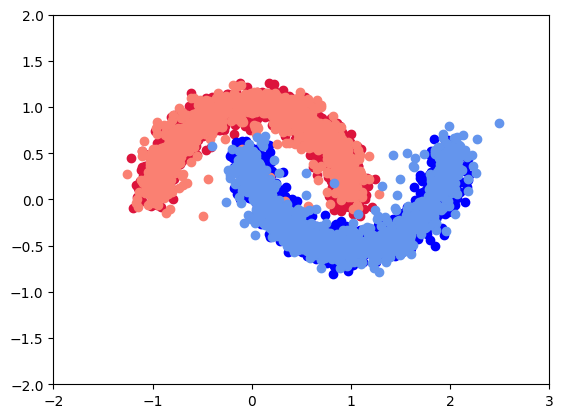

In [ ]:
n_samples = 1000
samples1 = model.sample(torch.randn(n_samples, 2), torch.zeros(n_samples, 1))
samples2 = model.sample(torch.randn(n_samples, 2), torch.ones(n_samples, 1))

targets1 = targets[y == 0]
targets2 = targets[y == 1]
plt.scatter(
    targets1[0:1000, 0].detach().numpy(),
    targets1[0:1000, 1].detach().numpy(),
    color="crimson",
)
plt.scatter(
    targets2[0:1000, 0].detach().numpy(),
    targets2[0:1000, 1].detach().numpy(),
    color="blue",
)
plt.scatter(
    samples1[:, 0].detach().numpy(), samples1[:, 1].detach().numpy(), color="salmon"
)
plt.scatter(
    samples2[:, 0].detach().numpy(),
    samples2[:, 1].detach().numpy(),
    color="cornflowerblue",
)
plt.xlim(-2, 3)
plt.ylim(-2, 2)
plt.show()

In [15]:
# make a model
model = ODEFlow(
    target_dimension=2,
    hidden_units=[256, 256],
    activation=nn.SiLU,
    target_shift=target_shift,
    target_scale=target_scale,
)

# training loop for the flow matching model

batch_size = 256

dataloader = DataLoader(
    TensorDataset(targets),
    shuffle=True,
    batch_size=batch_size,
)

# cosine scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
model.train()

epochs = 100
scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(dataloader), eta_min=1e-6)
with trange(epochs) as t:
    for epoch in t:
        for targets_ in dataloader:

            optimizer.zero_grad()

            loss = model.flow_matching_loss(targets_[0])

            loss.backward()

            optimizer.step()
            scheduler.step()

            t.set_postfix(ordered_dict={"loss": loss.detach().item()})

100%|██████████| 100/100 [02:10<00:00,  1.31s/it, loss=1.4]


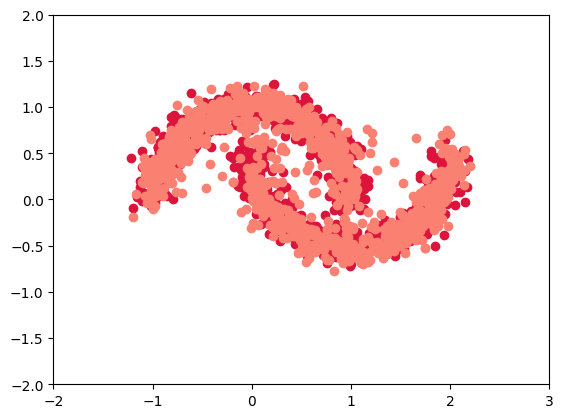

In [16]:
n_samples = 1000
samples = model.sample(torch.randn(n_samples, 2))

plt.scatter(
    targets[0:1000, 0].detach().numpy(),
    targets[0:1000, 1].detach().numpy(),
    color="crimson",
)

plt.scatter(
    samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), color="salmon"
)

plt.xlim(-2, 3)
plt.ylim(-2, 2)
plt.show()

In [17]:
# make a model
model = ODEFlow(
    target_dimension=2,
    hidden_units=[256, 256],
    activation=nn.SiLU,
    target_shift=target_shift,
    target_scale=target_scale,
)

# training loop for the flow matching model

batch_size = 128

dataloader = DataLoader(
    TensorDataset(targets),
    shuffle=True,
    batch_size=batch_size,
)

# cosine scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
model.train()

epochs = 100
scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(dataloader), eta_min=1e-6)
with trange(epochs) as t:
    for epoch in t:
        for targets_ in dataloader:

            optimizer.zero_grad()

            loss = -model.log_prob(targets_[0]).mean()

            loss.backward()

            optimizer.step()
            scheduler.step()

            t.set_postfix(ordered_dict={"loss": loss.detach().item()})

  1%|          | 1/100 [02:42<4:27:32, 162.15s/it, loss=1.17]


KeyboardInterrupt: 

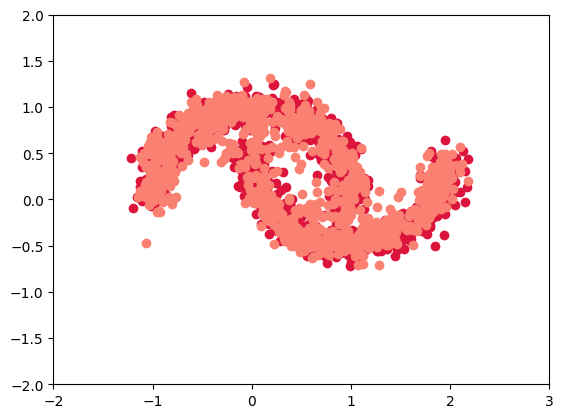

In [18]:
n_samples = 1000
samples = model.sample(torch.randn(n_samples, 2))

plt.scatter(
    targets[0:1000, 0].detach().numpy(),
    targets[0:1000, 1].detach().numpy(),
    color="crimson",
)

plt.scatter(
    samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), color="salmon"
)

plt.xlim(-2, 3)
plt.ylim(-2, 2)
plt.show()